In [43]:
import ipyparallel as ipp
from ipyparallel.util import interactive
import matplotlib.pyplot as plt
import pickle

In [44]:
from EM import EM
from plot import plot
import numpy as np

In [69]:
# display the average of estimated parameters along with std for multiple em runs of a single signal
# em_list store a list of em objects from multiple runs
def print_coeff(em_list, signal_name, plot_loglik=True, plot_mse=True):
    if signal_name == 'inr' or signal_name == 'inr_more_treatments':
        num_past_effects = 3
    else:
        num_past_effects = 2
    num_iter = len(em_list)
    treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    A = np.zeros((num_iter, num_past_effects, len(treatment_names.keys())))
    b = np.zeros((num_iter, len(chronic_keywords) + len(demographic_names)))
    transition_std = np.zeros(num_iter)
    observation_std = np.zeros(num_iter)
    initial_state_std = np.zeros(num_iter)
    initial_state_mean = np.zeros(num_iter)
    mse_list = []
    loglik_list = []
    for i, em in enumerate(em_list):
        A[i, :, :] = em.A
        b[i, :] = em.b
        initial_state_mean[i] =  em.init_z
        initial_state_std[i] = np.sqrt(em.sigma_0)
        transition_std[i] = np.sqrt(em.sigma_1)
        observation_std[i] = np.sqrt(em.sigma_2)
        mse_list.append(em.mse)
        loglik_list.append(em.obs_log_lik)
    
    print('{} coefficients averaged over {} runs'.format(signal_name, num_iter))
    for j in range(num_past_effects):
        print('past time point {}'.format(j+1))
        for i, treatment in enumerate(treatment_names.keys()):
            if num_iter > 1:
                print('{}: {}±{}'.format(treatment, np.round(np.average(A, axis=0)[j, i], 4), np.round(np.std(A, axis=0)[j, i], 4)))
            else:
                print('{}: {}'.format(treatment, np.round(np.average(A, axis=0)[j, i], 4)))
            
    static_types = np.concatenate([chronic_keywords, demographic_names])
    for j, static in enumerate(static_types):
        if num_iter > 1:
            print('{}: {}±{}'.format(static, np.round(np.average(b, axis=0)[j], 4), np.round(np.std(b, axis=0)[j], 4)))
        else:
            print('{}: {}'.format(static, np.round(np.average(b, axis=0)[j], 4)))
    
    if num_iter > 1:
        print('initial state mean: {}±{}'.format(np.round(np.average(initial_state_mean), 4), np.round(np.std(initial_state_mean), 4)))
        print('initial state std: {}±{}'.format(np.round(np.average(initial_state_std), 4), np.round(np.std(initial_state_std), 4)))
        print('transition noise (std): {}±{}'.format(np.round(np.average(transition_std), 4), np.round(np.std(transition_std), 4)))
        print('observation noise (std): {}±{}'.format(np.round(np.average(observation_std), 4), np.round(np.std(observation_std), 4)))
    else:
        print('initial state mean: {}'.format(np.round(np.average(initial_state_mean), 4)))
        print('initial state std: {}'.format(np.round(np.average(initial_state_std), 4)))
        print('transition noise (std): {}'.format(np.round(np.average(transition_std), 4)))
        print('observation noise (std): {}'.format(np.round(np.average(observation_std), 4)))
    
    if plot_loglik:
        for loglik in loglik_list:
            plt.plot([i for i in range(len(loglik))], loglik)
            plt.xlabel('Iterations')
            plt.ylabel('Observed data log likelihood')
            plt.title('EM log likelihood of {}'.format(signal_name))
            plt.show()
    if plot_mse:
        for mse in mse_list:
            plt.plot([i for i in range(len(mse))], mse)
            plt.xlabel('Iterations')
            plt.ylabel('MSE')
            plt.title('Prediction MSE of {}'.format(signal_name))
            plt.show()

In [49]:
signal_context = pickle.load(open('../Data/signal_context_new.pkl', 'rb'))

In [50]:
all_signals = list(signal_context.keys())

In [51]:
all_signals

['creatinine', 'bun', 'inr', 'lactate', 'platelets']

In [52]:
training_pct = .8
single_effect = False

### Parallel Training Set Up

In [53]:
rc = ipp.Client(profile='myprofile')

/home/bear/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@brahms')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [54]:
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [55]:
dview = rc[:]

In [56]:
import os
import signal
engine_pids = rc[:].apply(os.getpid).get_dict()

def signal_engine(engine_id, sig=signal.SIGINT):
    """send a signal to a local engine"""
    pid = engine_pids[engine_id]
    os.kill(pid, sig)

In [57]:
with dview.sync_imports():
    import numpy
%px np = numpy 

importing numpy on engine(s)


### Run EM on multiple signals once

In [58]:
# run em on a given signal
# return em object after convergence
def run_em_on_signal(signal_name):
    #import sys
    #sys.path.insert(0, '/home/bear/Documents/Counterfactual-Prediction/EM.py')
    import importlib
    import EM
    importlib.reload(EM)
    from EM import EM
    
    training_pct = .8
    single_effect = False
    if signal_name == 'inr' or 'inr_more_treatments':
        num_past_effects = 3
    else:
        num_past_effects = 2
    #treatment_names, chronic_keywords, demographic_names = signal_context[signal_name]
    data = np.load('../Data/'+signal_name+'_preprocessed_data.npz')
    em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
        X_prev = data['X_prev_mtx'], single_effect=single_effect)
    em.run_EM(20000)
    return em

In [20]:
test_signals = ['creatinine', 'bun', 'inr', 'lactate', 'platelets']

In [80]:
all_signals_params = dview.map(run_em_on_signal, test_signals)

In [84]:
all_signals_params.wait_interactive()

   5/5 tasks finished after 2380 s
done


creatinine coefficients averaged over 1 runs
dialysis: [-1.3203 -0.7576]
nephrotoxic_drugs: [-0.0164 -0.0248]
dronedarone: [-0.0652  0.1061]
diuretic: [0.0439 0.0179]
ace_i: [ 0.0097 -0.0042]
arb: [0.0916 0.0521]
chronic_kidney: 1.2426
kidney_cancer: 0.101
renal: 0.2447
esrd: 2.634
sickle_cell: 0.6886
gender: 0.2259
admit_weight: -0.0187
initial state mean: 2.7047
initial state std: 1.7847
transition noise (std): 0.4293
observation noise (std): 0.0918


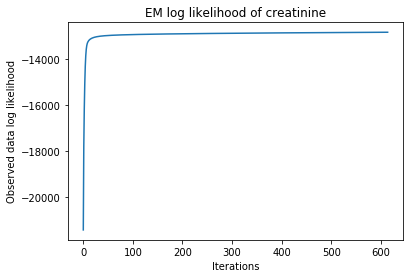

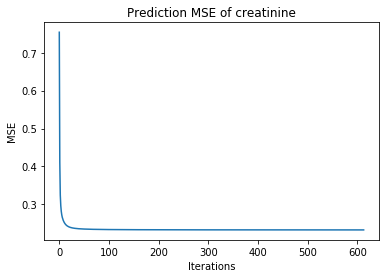

bun coefficients averaged over 1 runs
dialysis: [-13.6935  -8.9975]
diuretic: [0.5338 0.4335]
drugs_increase: [-0.5328 -0.4025]
chronic_kidney: 22.5714
kidney_cancer: 8.0412
renal: 9.1227
esrd: 13.3886
heart_failure: 6.8359
liver: 4.4214
initial state mean: 20.5142
initial state std: 20.0873
transition noise (std): 5.9069
observation noise (std): 0.5605


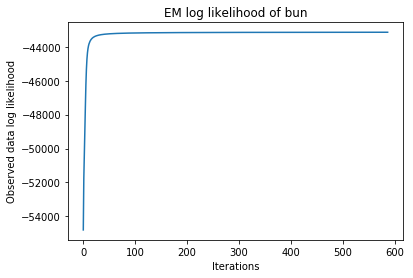

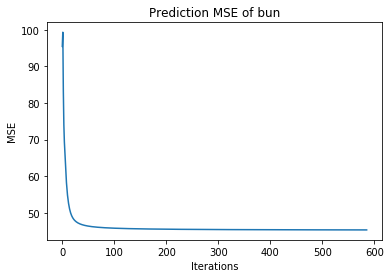

inr coefficients averaged over 1 runs
nsaid: [-0.0741 -0.1191 -0.1176]
anticoagulant: [-0.0141  0.2122  0.1417]
transfusion_platelets: [-0.1642 -0.2539 -0.1578]
liver_disease: 0.228
sickle_cell: -0.064
initial state mean: 2.2174
initial state std: 1.3492
transition noise (std): 0.6582
observation noise (std): 0.3161


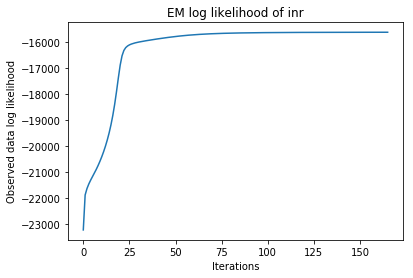

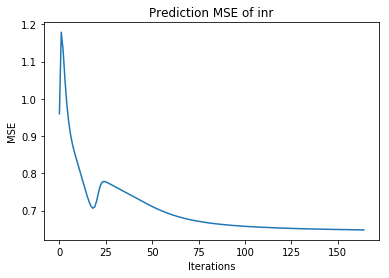

lactate coefficients averaged over 1 runs
ivf: [ 0.2739 -0.1248]
antibiotics: [-0.5708 -0.23  ]
drugs_elevate_lactate: [ 0.3011 -0.2751]
chronic_kidney: -0.2956
kidney_cancer: -2.9409
renal: -0.4525
esrd: -0.2138
diabete: -1.0573
liver: 1.7315
initial state mean: 4.5413
initial state std: 2.9069
transition noise (std): 2.1285
observation noise (std): 0.7467


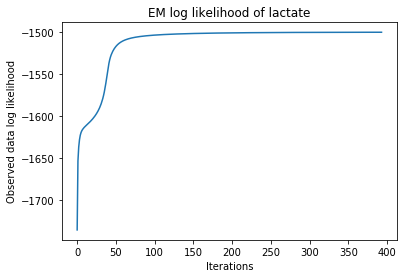

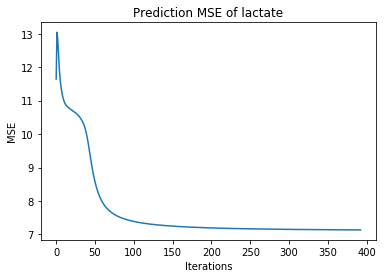

platelets coefficients averaged over 1 runs
platelets_transfusion: [6.9197 1.2143]
ditp: [-17.5464  -7.8111]
liver: -76.4661
sickle_cell: 63.9573
initial state mean: 226.1658
initial state std: 99.6646
transition noise (std): 23.3053
observation noise (std): 16.6558


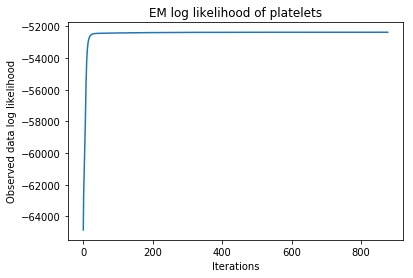

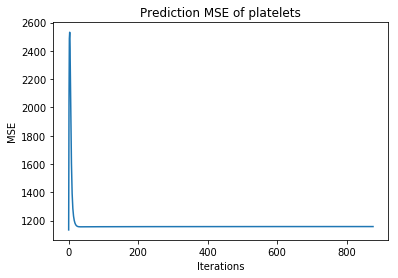

In [85]:
for i, signal_name in enumerate(test_signals):
    print_coeff([all_signals_params[i]], signal_name)

### Cross Validation for Initialization

In [96]:
# cross validation on the initialization of b and sigma 0
def cv_init(args):
    import importlib
    import EM
    importlib.reload(EM)
    from EM import EM

    signal_name, init = args
    data = np.load('../Data/'+signal_name+'_preprocessed_data.npz')
    em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], J=3, K=0, train_pct=.8, X_prev_given=True,
        X_prev = data['X_prev_mtx'], init_A_given=True, init_A=init, init_b_given=True, 
            init_b=np.zeros((data['c_mtx'].shape[1])), init_0=0.001, init_state=0, init_1=.01, init_2=.01)
    em.run_EM(20000)
    return em

In [105]:
init_choices = [0, np.sqrt(.001), -np.sqrt(.001), 2*np.sqrt(.001), -2*np.sqrt(.001), 3*np.sqrt(.001), -3*np.sqrt(.001)]
test_signals = ['inr_more_treatments']
grouped_args = [(signal, init) for signal in test_signals for init in init_choices]

In [107]:
cv_params = dview.map(cv_init, grouped_args)

In [108]:
cv_params.wait_interactive()

   2/2 tasks finished after  715 s
done


### Run EM on one signal multiple times

In [91]:
def single_signal_multi_runs(signal_name):
    import importlib
    import EM
    importlib.reload(EM)
    from EM import EM

    data = np.load('../Data/bun_test_preprocessed_data.npz')
    em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], J=2, K=0, train_pct=.8, X_prev_given=True,
        X_prev = data['X_prev_mtx'])
    em.run_EM(20000)
    return em

In [92]:
signal_name = 'bun'

In [93]:
multi_runs_params = dview.map(single_signal_multi_runs, [signal_name for i in range(8)])

In [94]:
multi_runs_params.wait_interactive()

   8/8 tasks finished after 8883 s
done


bun coefficients averaged over 8 runs
past time point 1
dialysis: -13.6866±0.0093
diuretics: 0.5396±0.0055
certain antibiotics: -0.5362±0.0024
past time point 2
dialysis: -8.9828±0.0211
diuretics: 0.4377±0.0047
certain antibiotics: -0.4039±0.001
liver: 8.1591±1.5445
chronic_kidney: 21.9519±3.5075
esrd: 32.3313±5.0585
renal: 10.0272±1.8133
heart_failure: 8.2576±2.2082
kidney_cancer: 7.6956±2.5731
initial state mean: 19.9633±1.7267
initial state std: 20.3409±0.1599
transition noise (std): 5.9147±0.0113
observation noise (std): 0.4571±0.1378


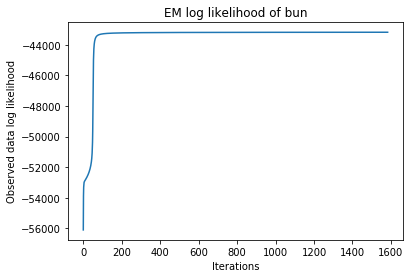

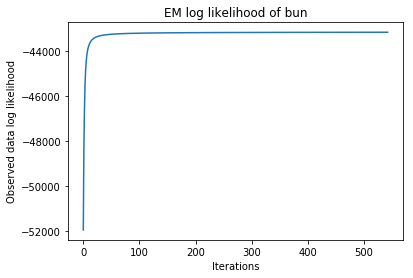

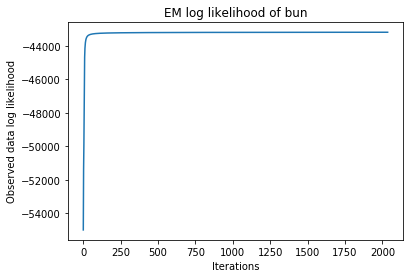

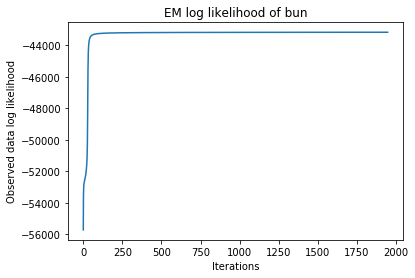

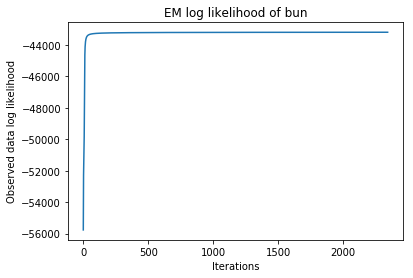

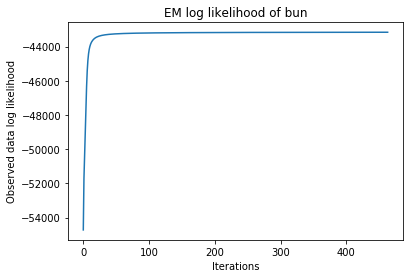

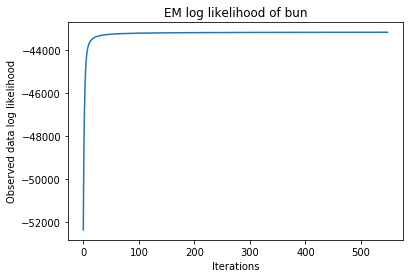

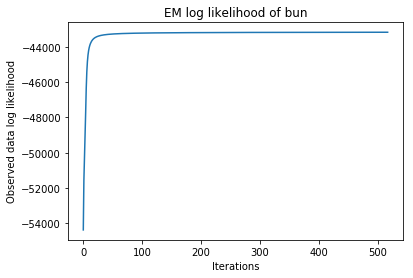

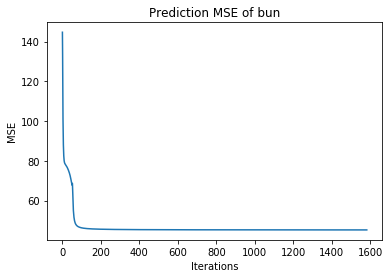

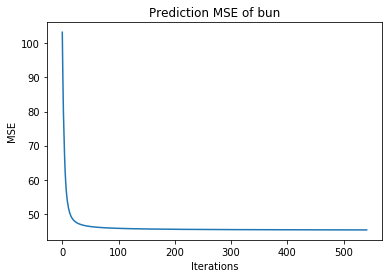

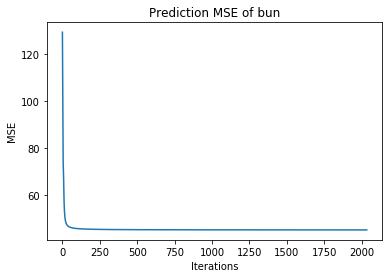

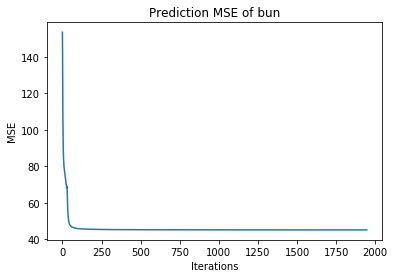

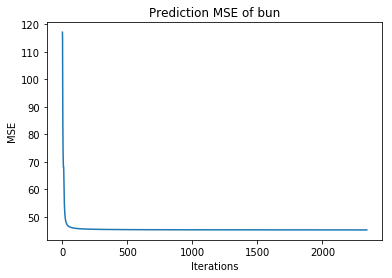

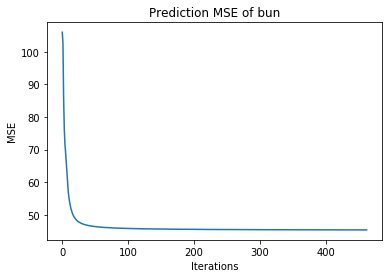

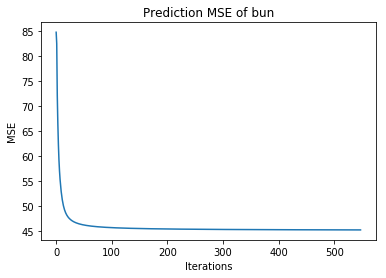

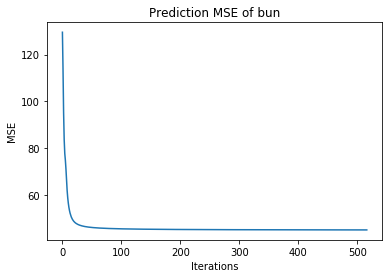

In [95]:
print_coeff(multi_runs_params.get(), signal_name)

### Plot trajectories for one EM instance

In [88]:
for i in range(8):
    print(multi_runs_params.get()[i].mse[-1])

0.234280747672145
0.23428193751679488
0.23376617748504055
0.23442210939499258
0.23435996116415567
0.23426320018338456
0.26980913325516825
0.2343030772592053


In [81]:
def find_min_mse_index(em_list):
    min_mse = np.inf
    min_mse_index = -1
    for i in range(len(em_list)):
        em = em_list[i]
        if em.mse[-1] < min_mse:
            min_mse = em.mse[-1]
            min_mse_index = i
    return min_mse_index

In [82]:
def find_max_loglik_index(em_list):
    max_lik = -np.inf
    max_lik_index = -1
    for i in range(len(em_list)):
        em = em_list[i]
        if em.obs_log_lik[-1] > max_lik:
            max_lik = em.obs_log_lik[-1]
            max_lik_index = i
    return max_lik_index

In [83]:
find_max_loglik_index(multi_runs_params.get())

7

In [84]:
find_min_mse_index(multi_runs_params.get())

2

creatinine coefficients averaged over 1 runs
past time point 1
dialysis: -1.3269
diuretics: 0.0412
ACE Inhibitors: 0.0063
ARB: 0.0915
nephrotoxic drugs: -0.0286
dronedarone: -0.0607
past time point 2
dialysis: -0.7827
diuretics: 0.0145
ACE Inhibitors: -0.008
ARB: 0.053
nephrotoxic drugs: -0.0214
dronedarone: 0.1149
liver: 0.4868
chronic_kidney: 1.199
esrd: 5.4538
renal: 0.3199
sickle_cell: 1.0125
kidney_cancer: 0.5426
admit_weight: 0.0043
gender: 0.1941
initial state mean: 0.7309
initial state std: 1.6168
transition noise (std): 0.4091
observation noise (std): 0.1467


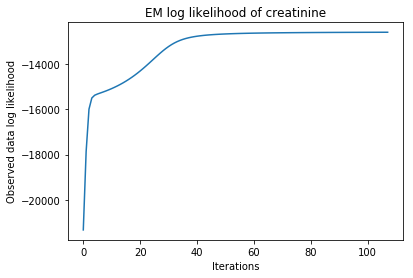

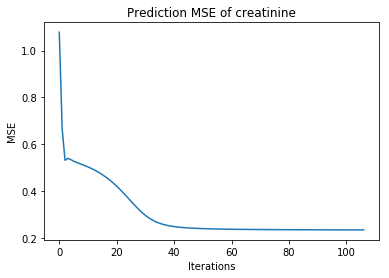

In [87]:
print_coeff([multi_runs_params.get()[2]], 'creatinine')

In [29]:
em = params[7]

In [15]:
have_treatment = np.array([   5,   18,   36,   63,  115,  119,  130,  140,  159,  181,  190,
        199,  218,  231,  241,  252,  299,  302,  313,  324,  328,  361,
        467,  473,  480,  484,  486,  503,  515,  547,  576,  599,  603,
        608,  656,  718,  735,  742,  754,  771,  776,  800,  809,  827,
        875,  903,  908,  954,  961,  984, 1017, 1028, 1040, 1045, 1057,
       1059, 1064, 1081, 1116, 1156, 1165, 1182, 1224, 1241, 1242, 1245,
       1285, 1287, 1307, 1318, 1323, 1378, 1406, 1432, 1446, 1531, 1534,
       1544, 1560, 1569, 1585, 1586, 1640, 1696, 1778, 1860, 1879, 1913,
       1949, 2013, 2018, 2123, 2227, 2294, 2330, 2336, 2370, 2395])

Patient 1949


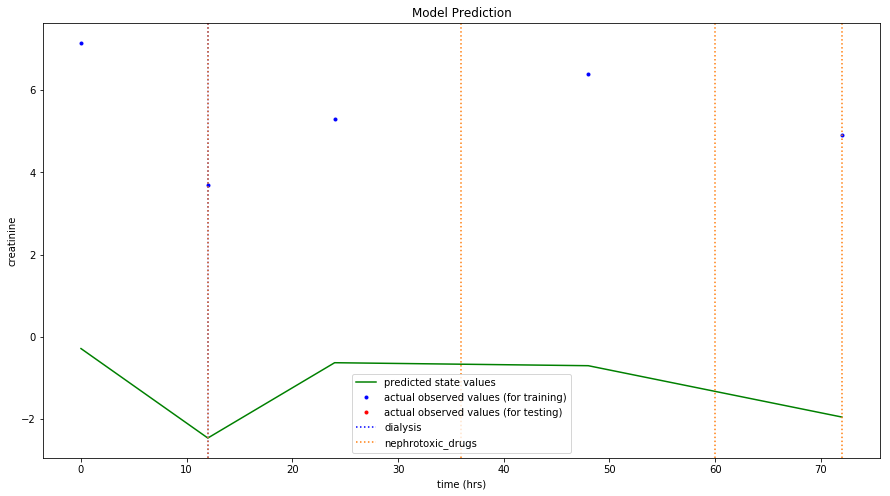

Patient 252


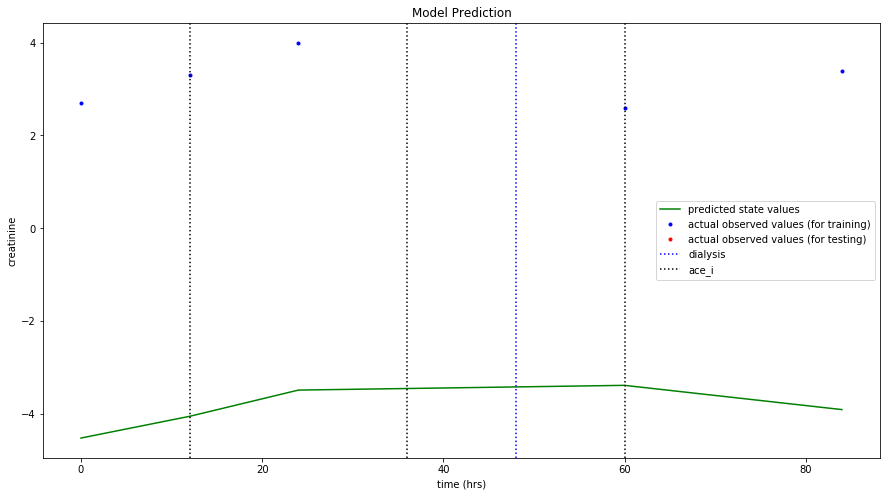

Patient 1165


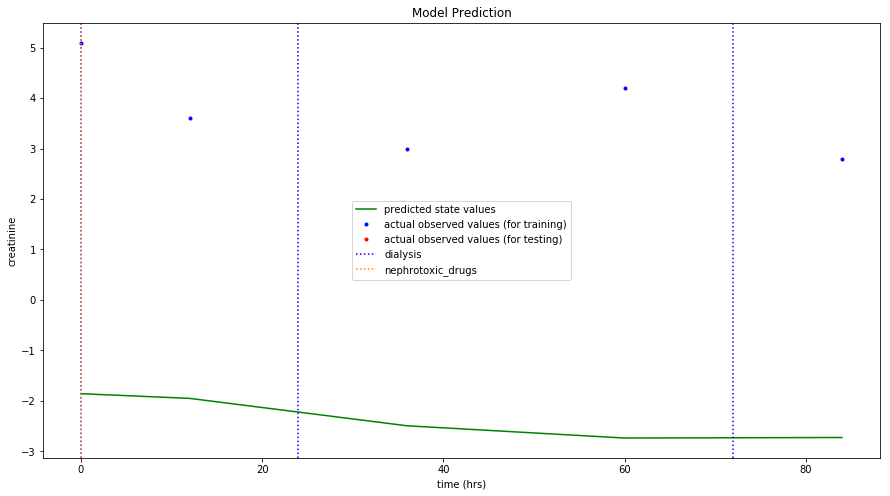

Patient 467


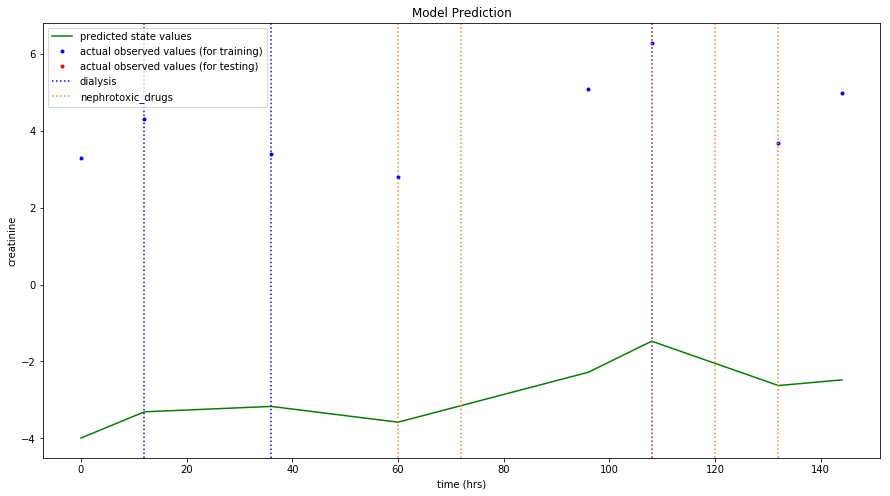

Patient 486


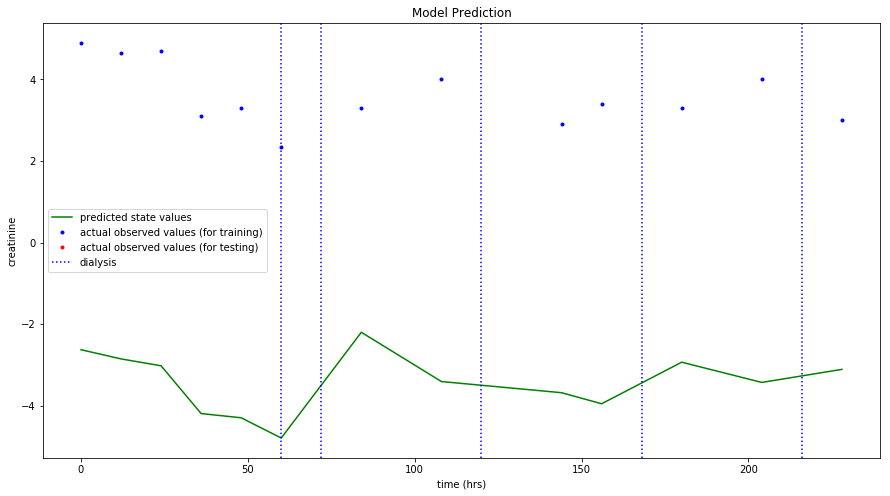

Patient 547


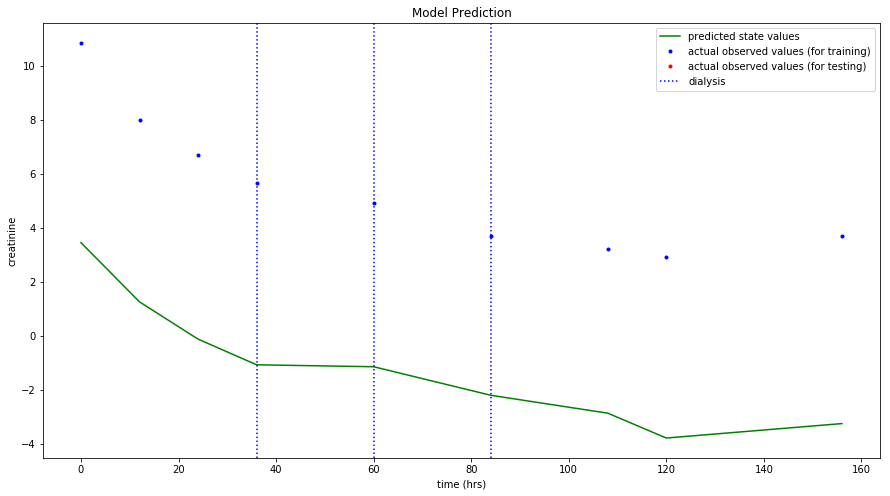

Patient 1242


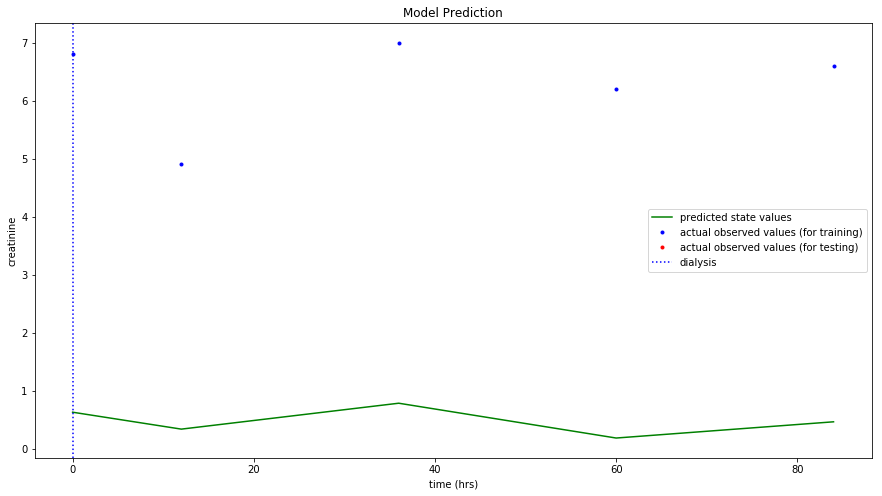

Patient 656


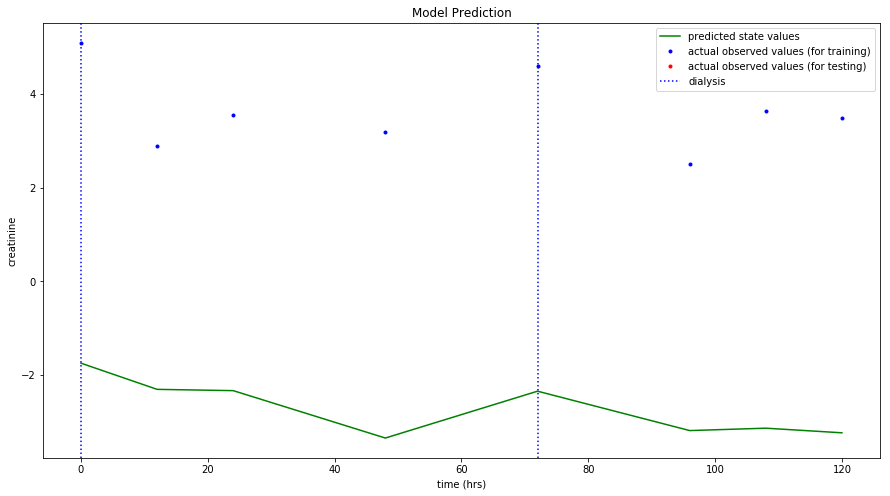

Patient 1245


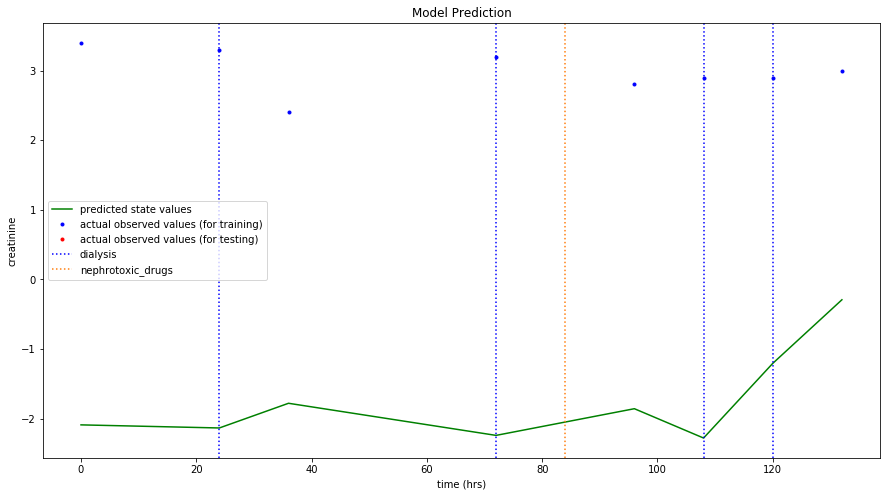

Patient 1432


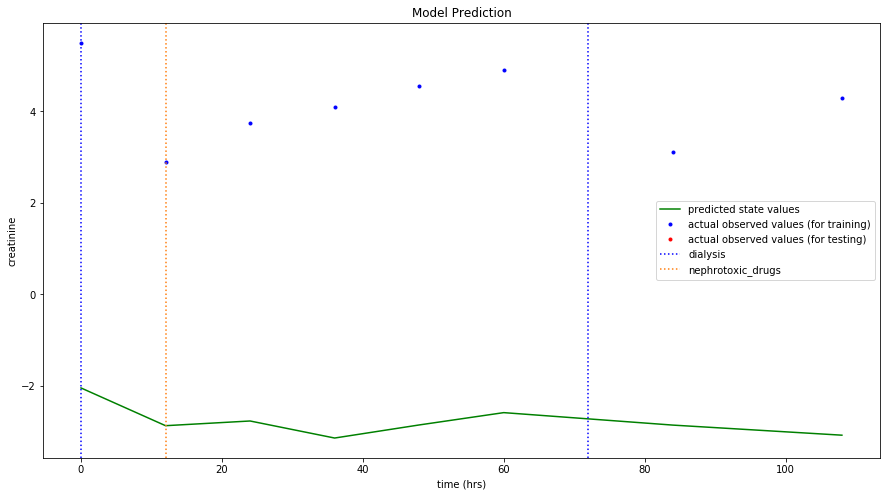

In [39]:
random_patients = np.random.choice(have_treatment, size=10, replace=False)#np.random.randint(0, em.y.shape[0], 20)
for i in random_patients:
    plot(em, i, 12, signal_name, treatment_types=list(signal_context[signal_name][0].keys()))